In [13]:
from wind_ae.wrapper.relax_wrapper import wind_simulation as wind_sim
import wind_ae.wrapper.wrapper_utils.constants as const
import wind_ae.McAstro.atoms.atomic_species as McAtom
from scipy.interpolate import CubicSpline
from scipy.special import exp1
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [5]:
sim = wind_sim()
sim.load_planet('data/HD209_13.6-2000eV_H-He.csv') #old soln

Atmosphere Composition
  Species:   HI,        HeI
  Mass frac: 8.00e-01, 2.00e-01



In [ ]:
def Interpolater(j,m,E_wl):
    '''Returns the interpolated secondary ionization rate coefficient for species m having
      been ionized by a photoelectron released from species j which was initially ionized 
      by a photon of energy E_wl (in ergs).
      
      Returns: R'''
    df = pd.read_csv('../../wind_ae/wrapper/wrapper_utils/dere_table29.dat',
                              sep=r'\s+', names=list(range(45)))  
    df = df.rename(columns={0:'Z', 1:'Ion', 2:'NS', 3:'I', 4:'Tmin'})
    species_new = sim.windsoln.species_list
    species_ionized = species_new[m]
    species_name_spaced = McAtom.formatting_species_list([species_ionized])[0]
    ma = McAtom.atomic_species(species_name_spaced)
    Z = ma.Z
    Ne = ma.Ne
    species_ionizing = species_new[j]
    species_name_spaced = McAtom.formatting_species_list([species_ionizing])[0]
    ma = McAtom.atomic_species(species_name_spaced)
    ion_pot_m = ma.ion_pot

    Ion = Z-Ne+1
    dere = df[(df['Z']==Z)&(df['Ion']==Ion)].values[0][5:]
    dere = dere[np.isnan(dere)==False]
    split = len(dere)//2

    x = dere[:split]
    rho = dere[split:]
    I = df[(df['Z']==Z)&(df['Ion']==Ion)]['I'].values[0]
    k = 8.67e-5  # eV/K
    f = 2
    T = (I/k)*(np.exp(np.log(f)/(1-x))-f)
    E = k*T
    t = (k*T)/I
    R = t**(-1/2)*I**(-3/2)*rho*exp1(1/t)
    # spline = interp.CubicSpline(E[(E>40)&(E<ulim)]*const.eV,R[(E>40)&(E<ulim)])
    spline = CubicSpline(E*const.eV,R)

    E0 = E_wl - ion_pot_m #energy left after ionizing species m
    return spline(E0)

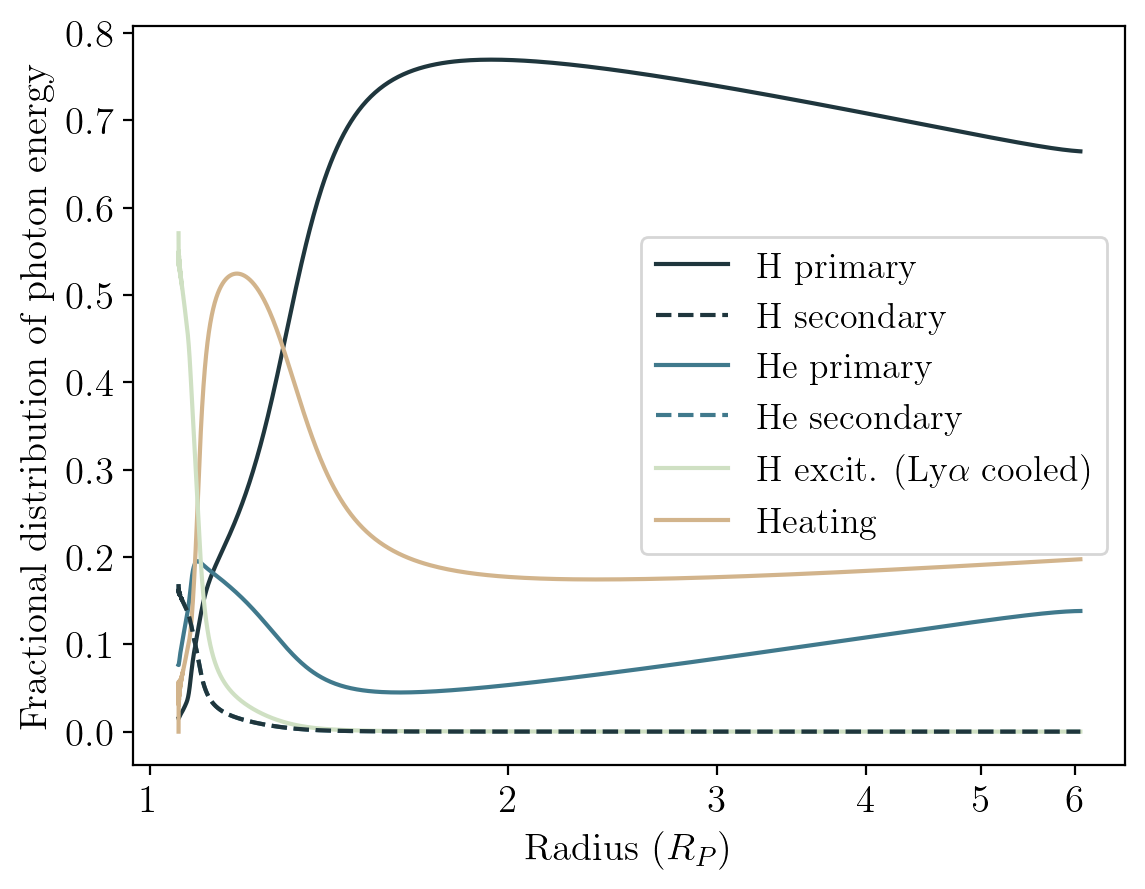

frac into ionizing H: 0.25
frac into ionizing He: 0.21
frac into Lya cooling: 0.15
frac into heating: 0.38
Heating efficiency: 0.24054089459054578


In [ ]:
r = sim.windsoln.soln_norm['r']
primary_ion_rate = np.zeros((len(r),sim.windsoln.nspecies))
secondary_ion_rate = np.zeros((len(r),sim.windsoln.nspecies))
secondary_H_rate = np.zeros_like(r)
secondary_He_rate = np.zeros_like(r)
secondary_metal_rate = np.zeros_like(r)
heating_rate = np.zeros_like(r)
excite_H_rate = np.zeros_like(r)
excite_He_rate = np.zeros_like(r)

x = sim.windsoln.soln['n_HII']/sim.windsoln.soln['n_H']
#if photoelectron energy > 40 eV
frac_in_heat = 0.9971*(1-(1-x**0.2663)**1.3163)
frac_in_ion_H = 0.3908*(1-x**0.4092)**1.7592
frac_in_ion_He = 0.0554*(1-x**0.4614)**1.6660
excite_H = 0.4766*(1-x**0.2735)**1.5221
excite_He = 0.0246*(1-x**0.4049)**1.6594
frac_in_ion_tot = 1 - frac_in_heat - excite_H

Lya_energy = const.hc/(1215.67*1e-8)

def rate(s,i,heating_rate=False):
    '''Returns the photoionization OR heating rate per unit volume of species 
    at (index s) and frequency at (index i). Written in this confusing way to save space'''
    species = sim.windsoln.species[s]
    n0_s = sim.windsoln.soln['n_'+species]
    sigma_s = sim.windsoln.sigma_wl[i,s]

    tau = sim.windsoln.taus[:,i]
    f_s = sigma_s*sim.windsoln.soln['Ncol_'+species]/tau
    Phi = sim.windsoln.Ftot * sim.windsoln.wPhi_wl[i] * np.exp(-tau)
    ion_pot = sim.windsoln.ion_pot[s]
    if heating_rate == False:
        #photoionization rate per species per unit volume
        return n0_s * sigma_s * f_s * Phi
    else:
        return n0_s * (E-ion_pot) * sigma_s * f_s * Phi


for i,E in enumerate(sim.windsoln.E_wl):
    for s,species in enumerate(sim.windsoln.species):
       primary_ion_rate[:,s] += rate(s,i)
       if (E-sim.windsoln.ion_pot[s]) > 6.4e-11:
            heating_rate += frac_in_heat*rate(s,i,heating_rate=True)
            excite_H_rate += excite_H*(E-sim.windsoln.ion_pot[s])/Lya_energy * rate(s,i) 
       else:
            heating_rate += rate(s,i,heating_rate=True)

       for m, species_m in enumerate(sim.windsoln.species):
            E0_m = (E-sim.windsoln.ion_pot[m])
            R_tot = 0
            for mm,species_mm in enumerate(sim.windsoln.species):
                n0_mm = sim.windsoln.soln['n_'+species_mm]
                R_tot += Interpolater(m,mm,E0_m)*n0_mm
            # print(sim.windsoln.Interpolater(sim.windsoln.Z[mm],sim.windsoln.Ne[mm])(E0_m)*n0_mm)

            #The Shull & van Steenberg (1985) secondary ionization equations are valid above 100 eV 
            #we have confirmed that the difference with 40 eV cutoff is negligible
            if E0_m > 6.4e-11:
                R = Interpolater(m,mm,E0_m)*sim.windsoln.soln['n_'+species_m]
                frac_in_ion_s = R/R_tot
                eta_s = frac_in_ion_tot*frac_in_ion_s*E0_m/sim.windsoln.ion_pot[s]
                secondary_ion_rate[:,s] += eta_s*rate(m,i)

secondary_H_rate = secondary_ion_rate[:,0]
secondary_He_rate = secondary_ion_rate[:,1]

total = (primary_ion_rate[:,0]+secondary_H_rate)*sim.windsoln.ion_pot[0]
total += (primary_ion_rate[:,1]+secondary_He_rate)*sim.windsoln.ion_pot[1]
total += excite_H_rate*Lya_energy 
total += heating_rate

fig,ax = plt.subplots()
ax.plot(r,primary_ion_rate[:,0]*sim.windsoln.ion_pot[0]/total,label='H primary',c='#1F363D')
ax.plot(r,secondary_H_rate*sim.windsoln.ion_pot[0]/total,label='H secondary',c='#1F363D',ls='--',zorder=500)
ax.plot(r,primary_ion_rate[:,1]*sim.windsoln.ion_pot[1]/total,label='He primary',c='#40798C')
ax.plot(r,secondary_He_rate*sim.windsoln.ion_pot[1]/total,label='He secondary',ls='--',c='#40798C')
ax.plot(r,excite_H_rate*Lya_energy/total,zorder=100,label=r'H excit. (Ly$\alpha$ cooled)',c='#CFE0C3')
ax.plot(r,heating_rate/total,label='Heating',c='tan')
ax.set_ylabel(r'Fractional distribution of photon energy')
ax.set_xlabel('Radius ($R_P$)')
ax.legend(loc='center right',fontsize=13)
plt.xscale('log')
plt.xticks([1,2,3,4,5,6],['1','2','3','4','5','6'])
plt.show()

print('frac into ionizing H: %.2f' %(sum((primary_ion_rate[:,0]+secondary_H_rate)*sim.windsoln.ion_pot[0])/sum(total)))
print('frac into ionizing He: %.2f'%(sum((primary_ion_rate[:,1]+secondary_He_rate)*sim.windsoln.ion_pot[1])/sum(total)))
print('frac into Lya cooling: %.2f' %(sum(excite_H_rate*Lya_energy)/sum(total)))
print('frac into heating: %.2f' %(sum(heating_rate)/sum(total)))
print("Mean heating efficiency:",np.mean(heating_rate/total))